## Transcribing with Whisper Locally

In [ ]:
import os
import csv
from pathlib import Path
import torch
from stable_whisper import load_model

# === SETTINGS ===
root_dir = r"C:\Pasha-PoC\Audio-Data"
output_csv = r"C:\Pasha-PoC\transcriptions_pasha.csv"  # ✅ Saving here
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# === LOAD MODEL ===
model = load_model("large-v3", device=device)

# === HELPER FUNCTION ===
def transcribe_audio_files(directory):
    results = []

    # Walk through all subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith((".wav", ".mp3", ".m4a")):
                filepath = os.path.join(root, filename)
                print(f"🎧 Transcribing: {filepath}")

                try:
                    result = model.transcribe(filepath, language="az")
                    text = result.text.strip()

                    if text:
                        label = filename  # ✅ Change to `os.path.splitext(filename)[0]` for saving without extension
                        results.append([text, label])
                except Exception as e:
                    print(f"⚠️ Failed to transcribe {filename}: {e}")
    return results

# === PROCESS ===
transcriptions = transcribe_audio_files(root_dir)

# === SAVE TO CSV ===
if transcriptions:
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Transcription", "Label"])  # Header
        writer.writerows(transcriptions)

    print(f"✅ Transcriptions saved to {output_csv}")
else:
    print("❌ No transcriptions were generated.")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("transcriptions_pasha.csv")
display(df)

## Data Preparation

In [ ]:
import os
import re
from datasets import Dataset, Audio as HF_Audio
from pydub import AudioSegment
import numpy as np

# --- 1. Settings ---
audio_dir      = r"C:\Pasha-PoC\Audio-Data"
transcript_dir = r"C:\Pasha-PoC\Audio-Data\transcripts"
target_sr      = 16_000

# --- 2. The Robust Hybrid Parsing Function ---
def parse_transcript(transcript_path):
    """
    Parses transcripts by trying a simple, common pattern first, then falling
    back to a more complex pattern for other formats. This ensures maximum
    compatibility without losing records.
    """
    
    # Pattern 1: The original, high-volume format [MM:SS] Speaker: text
    simple_pattern = re.compile(r'\[\s*(\d{2}):(\d{2})\s*\]\s*(.*?):\s*(.*)')

    # Pattern 2: A flexible pattern for m/s/ms formats, ranges, and text inside/outside brackets
    # This pattern is carefully designed not to overlap with the simple one.
    flexible_pattern = re.compile(
        r'\[\s*'
        r'(?:(\d+)\s*m\s*)?'  # Optional minutes
        r'(\d+)\s*s'          # Seconds are REQUIRED to distinguish from [MM:SS]
        r'(?:(\d+)\s*ms)?'   # Optional milliseconds
        r'\s*(?:-\s*'         # Optional range start
        r'(?:(\d+)\s*m\s*)?'
        r'(?:(\d+)\s*s\s*)?'
        r'(?:(\d+)\s*ms)?'
        r'\s*)?'
        r'([^\]]*)?'          # Optional text inside the bracket
        r'\s*\]\s*'
        r'(.*)?'              # Optional text outside the bracket
        r'$'
    )
    
    timed_segments = []
    
    try:
        with open(transcript_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        return []

    for line in lines:
        start_time, end_time, full_text = None, None, None

        # --- Step 1: Try the simple, proven pattern first ---
        match = simple_pattern.match(line)
        if match:
            minutes, seconds, speaker, text = match.groups()
            start_time = int(minutes) * 60 + int(seconds)
            full_text = text.strip()

        # --- Step 2: If the simple pattern failed, try the flexible one ---
        else:
            match = flexible_pattern.match(line)
            if match:
                sm, ss, sms, em, es, ems, text_inside, text_outside = match.groups()
                
                # Combine text and clean it
                full_text = f"{text_inside or ''} {text_outside or ''}".strip()
                full_text = re.sub(r'^\s*\w+:\s*', '', full_text).strip()
                
                # Calculate start and end times
                start_time = (int(sm) * 60 if sm else 0) + (int(ss) if ss else 0) + (int(sms) / 1000.0 if sms else 0)
                if any(t is not None for t in [em, es, ems]):
                    end_time = (int(em) * 60 if em else 0) + (int(es) if es else 0) + (int(ems) / 1000.0 if ems else 0)

        # --- Step 3: If a match was found and text exists, add it ---
        if start_time is not None and full_text:
            timed_segments.append({'start_time': start_time, 'end_time': end_time, 'text': full_text})

    if not timed_segments:
        return []

    # Sort segments and fill in missing end times
    timed_segments.sort(key=lambda x: x['start_time'])
    for i, segment in enumerate(timed_segments):
        if segment['end_time'] is None:
            if i + 1 < len(timed_segments):
                # Ensure the next segment doesn't start before the current one ends
                if timed_segments[i+1]['start_time'] > segment['start_time']:
                    segment['end_time'] = timed_segments[i+1]['start_time']
    
    return timed_segments


# --- 3. Main processing loop ---
records = []
print(f"🔍 Starting to process transcripts in: {transcript_dir}")

for dirpath, _, filenames in os.walk(transcript_dir):
    for fn in filenames:
        if not fn.lower().endswith(".txt"):
            continue

        txt_path = os.path.join(dirpath, fn)
        base_name, _ = os.path.splitext(fn)
        audio_path = os.path.join(audio_dir, base_name + ".wav")
        
        if not os.path.exists(audio_path):
            print(f"⚠️ Warning: Audio file not found for transcript '{fn}'.")
            continue
            
        print(f"🎤 Processing transcript '{fn}' with its audio.")
        
        segments = parse_transcript(txt_path)
        
        if not segments:
            print(f"⚠️ Warning: No valid segments parsed from {txt_path}. Skipping.")
            continue

        try:
            audio = AudioSegment.from_file(audio_path)
            audio = audio.set_frame_rate(target_sr)
            audio = audio.set_channels(1)
        except Exception as e:
            print(f"❌ Error loading audio file {audio_path}: {e}")
            continue
        
        for segment in segments:
            start_ms = segment['start_time'] * 1000
            
            if segment['end_time'] is not None:
                end_ms = segment['end_time'] * 1000
            else:
                # If it's the last segment, use audio duration
                end_ms = len(audio)
            
            if start_ms >= end_ms:
                continue

            clip = audio[start_ms:end_ms]
            
            if len(clip) < 100 or not segment.get('text'):
                continue

            clip_samples = np.array(clip.get_array_of_samples()).astype(np.float32) / 32768.0

            records.append({
                "audio": {"array": clip_samples, "sampling_rate": target_sr},
                "text": segment["text"]
            })

print(f"\n✅ Generated {len(records)} records from all transcripts.")

# --- 4. Build and save the final Hugging Face Dataset ---
if records:
    ds = Dataset.from_list(records)
    ds = ds.cast_column("audio", HF_Audio(sampling_rate=target_sr))
    
    output_path = "./manual_transcription_dataset"
    ds.save_to_disk(output_path, max_shard_size="500MB")
    
    print(f"\n🎉 Successfully created and saved dataset to '{output_path}'")
    print("\nDataset structure:")
    print(ds)
else:
    print("\n❌ No records were generated. Please check your file paths and formats.")

### Data Inspection

In [ ]:
from datasets import load_from_disk
import random
import IPython.display as ipd

# 1. Load your dataset from disk
dataset_path = "./manual_transcription_dataset"
ds = load_from_disk(dataset_path)

print("Dataset loaded successfully!")
print(ds)

# 2. Let's inspect a few random samples
for _ in range(5):  # We'll check 5 random samples
    # Get a random index
    random_index = random.randint(0, len(ds) - 1)
    
    # Retrieve the sample
    sample = ds[random_index]
    
    text = sample["text"]
    audio = sample["audio"]
    
    print("-" * 50)
    print(f"Sample Index: {random_index}")
    print(f"Text:         '{text}'")
    
    # 3. Create and display the audio player
    # The 'array' is the audio data, and 'sampling_rate' is needed for correct playback
    print("Audio:")
    display(ipd.Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print("-" * 50)

In [ ]:
import numpy as np

# Let's calculate durations and text lengths for the first 100 samples
print("Checking the first 100 samples for duration and text length issues...")
print("-" * 80)
print(f"{'Index':<8} | {'Duration (s)':<15} | {'Text Length':<15} | {'Text'}")
print("-" * 80)

for i in range(min(100, len(ds))): # Check up to 100 samples
    sample = ds[i]
    audio_array = sample["audio"]["array"]
    sr = sample["audio"]["sampling_rate"]
    text = sample["text"]
    
    # Calculate duration in seconds
    duration = len(audio_array) / sr
    
    # Check for potential issues
    if duration < 0.5 or duration > 30.0 or len(text) < 3:
        print("🚩 POTENTIAL ISSUE FOUND 🚩")
        
    print(f"{i:<8} | {duration:<15.2f} | {len(text):<15} | {text[:80]}") # Print first 80 chars of text

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

print("Analyzing the entire dataset...")

# This might take a moment as it processes all N items in our dataset
# We're creating two new columns: 'duration' and 'text_length'
def compute_stats(batch):
    batch["duration"] = [len(x["array"]) / x["sampling_rate"] for x in batch["audio"]]
    batch["text_length"] = [len(x) for x in batch["text"]]
    return batch

ds_with_stats = ds.map(compute_stats, batched=True, batch_size=100)

# Convert to a pandas DataFrame for easy plotting
df = ds_with_stats.to_pandas()

print("\nBasic statistics for the dataset:")
print(df[["duration", "text_length"]].describe())


# --- Plotting the Histograms ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot audio duration histogram
df['duration'].hist(bins=50, ax=ax1)
ax1.set_title('Distribution of Audio Durations (seconds)')
ax1.set_xlabel('Duration (s)')
ax1.set_ylabel('Number of Samples')

# Plot text length histogram
df['text_length'].hist(bins=50, ax=ax2)
ax2.set_title('Distribution of Text Lengths (characters)')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

### Post-Processing

In [ ]:
from datasets import load_from_disk

# 1. Load the dataset we just created
dataset_path = "./manual_transcription_dataset"
ds = load_from_disk(dataset_path)
print(f"Original dataset size: {len(ds)}")

# 2. Define our filtering criteria
MIN_TEXT_LENGTH = 3      # Minimum number of characters in the text
MAX_TEXT_LENGTH = 400    # Maximum number of characters (optional, good for sanity)
MIN_AUDIO_SECONDS = 0.5  # Minimum duration of audio in seconds
MAX_AUDIO_SECONDS = 25.0 # Maximum duration of audio. Anything over this is likely a parsing error.

def is_good_sample(sample):
    """
    Our main filtering function. 
    Returns True if the sample is good, False otherwise.
    """
    text = sample["text"]
    audio = sample["audio"]
    
    # Calculate duration
    duration = len(audio["array"]) / audio["sampling_rate"]
    
    # Apply all our rules
    if (len(text) < MIN_TEXT_LENGTH or 
        len(text) > MAX_TEXT_LENGTH or
        duration < MIN_AUDIO_SECONDS or
        duration > MAX_AUDIO_SECONDS):
        return False
        
    return True

# 3. Apply the filter
# The .filter() method is highly efficient and will create a new, clean dataset.
cleaned_ds = ds.filter(is_good_sample) # Use multiple processors to speed it up (n_proc)

print(f"Cleaned dataset size: {len(cleaned_ds)}")
print(f"Number of samples removed: {len(ds) - len(cleaned_ds)}")

# 4. (Optional but Recommended) Save the new, cleaned dataset
cleaned_dataset_path = "./manual_transcription_dataset"
cleaned_ds.save_to_disk(cleaned_dataset_path)

print(f"\n🎉 Successfully created and saved CLEANED dataset to '{cleaned_dataset_path}'")
print("\nNew Cleaned Dataset structure:")
print(cleaned_ds)

In [ ]:
from datasets import load_from_disk
import random
import IPython.display as ipd

# 1. Load your dataset from disk
dataset_path = "./manual_transcription_dataset"
ds = load_from_disk(dataset_path)

print("Dataset loaded successfully!")
print(ds)

# 2. Let's inspect a few random samples
for _ in range(5):  # We'll check 5 random samples
    # Get a random index
    random_index = random.randint(0, len(ds) - 1)
    
    # Retrieve the sample
    sample = ds[random_index]
    
    text = sample["text"]
    audio = sample["audio"]
    
    print("-" * 50)
    print(f"Sample Index: {random_index}")
    print(f"Text:         '{text}'")
    
    # 3. Create and display the audio player
    # The 'array' is the audio data, and 'sampling_rate' is needed for correct playback
    print("Audio:")
    display(ipd.Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print("-" * 50)

In [ ]:
import numpy as np

# Let's calculate durations and text lengths for the first 100 samples
print("Checking the first 100 samples for duration and text length issues...")
print("-" * 80)
print(f"{'Index':<8} | {'Duration (s)':<15} | {'Text Length':<15} | {'Text'}")
print("-" * 80)

for i in range(min(100, len(ds))): # Check up to 100 samples
    sample = ds[i]
    audio_array = sample["audio"]["array"]
    sr = sample["audio"]["sampling_rate"]
    text = sample["text"]
    
    # Calculate duration in seconds
    duration = len(audio_array) / sr
    
    # Check for potential issues
    if duration < 0.5 or duration > 30.0 or len(text) < 3:
        print("🚩 POTENTIAL ISSUE FOUND 🚩")
        
    print(f"{i:<8} | {duration:<15.2f} | {len(text):<15} | {text[:80]}") # Print first 80 chars of text

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

print("Analyzing the entire dataset...")

# This might take a moment as it processes all N items in our dataset
# We're creating two new columns: 'duration' and 'text_length'
def compute_stats(batch):
    batch["duration"] = [len(x["array"]) / x["sampling_rate"] for x in batch["audio"]]
    batch["text_length"] = [len(x) for x in batch["text"]]
    return batch

ds_with_stats = ds.map(compute_stats, batched=True, batch_size=100)

# Convert to a pandas DataFrame for easy plotting
df = ds_with_stats.to_pandas()

print("\nBasic statistics for the dataset:")
print(df[["duration", "text_length"]].describe())


# --- Plotting the Histograms ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot audio duration histogram
df['duration'].hist(bins=50, ax=ax1)
ax1.set_title('Distribution of Audio Durations (seconds)')
ax1.set_xlabel('Duration (s)')
ax1.set_ylabel('Number of Samples')

# Plot text length histogram
df['text_length'].hist(bins=50, ax=ax2)
ax2.set_title('Distribution of Text Lengths (characters)')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

## Fine-Tuning

In [2]:
# 1. Check for GPU
import torch
print("🚀 Using device:", "cuda" if torch.cuda.is_available() else "cpu")

# 2. Install dependencies (uncomment if running in a fresh environment)
# !pip install -q datasets>=2.6.1 transformers>=4.30.0 accelerate librosa evaluate jiwer soundfile

# 3. Imports
import os
from datasets import load_from_disk, Audio
from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
import evaluate
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

# 4. Load your dataset
ds = load_from_disk("./manual_transcription_dataset")
print(ds)

# 5. Cast audio column to the 16 kHz Whisper format
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))

# 6. Load Whisper processor for "small" and set to Azerbaijani
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
tokenizer = WhisperTokenizer.from_pretrained(
    "openai/whisper-small",
    language="Azerbaijani",   # Whisper’s language token
    task="transcribe"
)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small",
    language="Azerbaijani",
    task="transcribe"
)

# 7. Prepare the dataset: compute log-Mel inputs and tokenize transcripts
def prepare_batch(batch):
    # load + resample audio
    audio_arr = batch["audio"]["array"]
    sr = batch["audio"]["sampling_rate"]
    # feature extraction
    features = feature_extractor(audio_arr, sampling_rate=sr).input_features[0]
    # tokenize
    labels = tokenizer(batch["text"]).input_ids
    return {"input_features": features, "labels": labels}

ds = ds.map(
    prepare_batch,
    remove_columns=ds.column_names,
    num_proc=1
)

# Split into train & test sets
ds = ds.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = ds["train"], ds["test"]

# 8. Data collator to batch and pad correctly
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any  # the WhisperProcessor

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # separate audio inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        inputs = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(inputs, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        label_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = label_batch["input_ids"].masked_fill(label_batch.attention_mask.ne(1), -100)
        
        # remove leading bos (beginning of a sentence) if present:
        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# 9. Load WER metric
wer_metric = evaluate.load("wer")

# We need to craft a function that processes our model predictions and calculates the WER metric. 
# This function, named `compute_metrics`, initially substitutes `-100` with the `pad_token_id` in the `label_ids`, 
# reversing the adjustment made in the data collator to accurately exclude padded tokens from the loss calculation. 
# Subsequently, it translates the predicted and label ids into strings. 
# Ultimately, it determines the WER by comparing the predictions with the reference labels:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


# 10. Load the pretrained Whisper-Small model
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.generation_config.language = "az" # Set decoding language
model.generation_config.task = "transcribe"

# Adjust generation parameters - no tokens are predetermined as decoder outputs, and 
# no tokens are excluded during the generation process
model.generation_config.forced_decoder_ids = None
model.generation_config.suppress_tokens    = []

# 11. Setup training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-az-small-finetuned",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4, # (2 * 4 = 8)
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    fp16=True,
    predict_with_generate=True,
    generation_max_length=225,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

# 12. Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=data_collator,
    tokenizer=processor.feature_extractor, # or tokenizer=processor - the whole processor, which knows how to pad both audio and text
    compute_metrics=compute_metrics,
)

# 13. Save processor (necessary for inference)
processor.save_pretrained(training_args.output_dir)

# 14. Launch training
trainer.train()

C:\LLM Instruction Fine-Tuning\.venv\Lib\site-packages\accelerate\accelerator.py:439: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Wer
0,0.807300,0.764744,128.246380
1,0.405600,0.695376,118.639393
2,0.291900,0.690892,114.249598
4,0.070800,0.752177,118.087796


There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=3175, training_loss=0.3999003756140161, metrics={'train_runtime': 4227.5862, 'train_samples_per_second': 6.014, 'train_steps_per_second': 0.751, 'total_flos': 7.32891482652672e+18, 'train_loss': 0.3999003756140161, 'epoch': 4.99})

In [ ]:
print("Saving the final, best model to the output directory...")
trainer.save_model() 
print("Model saved successfully.")

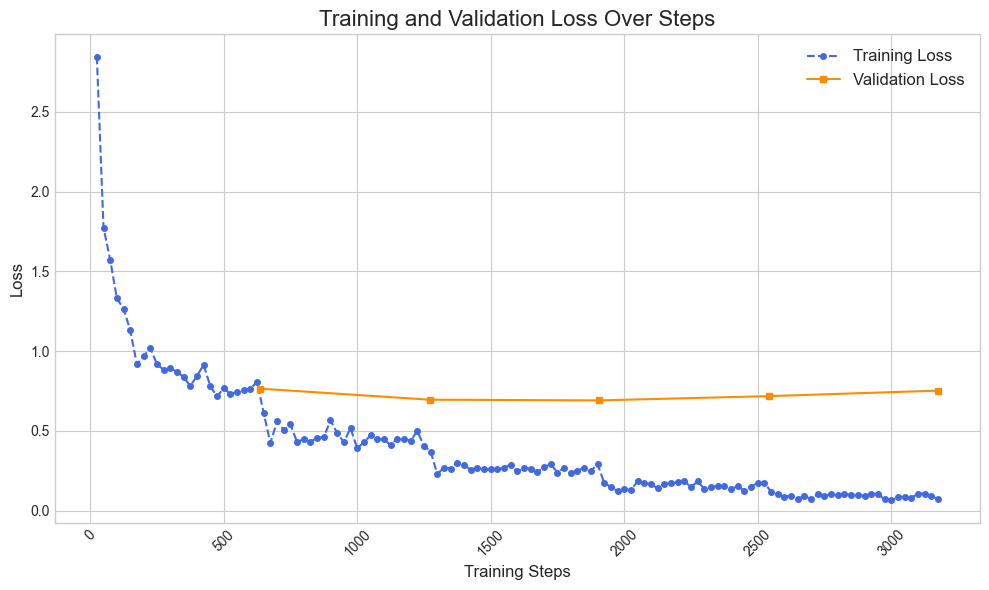

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Access the training history
# The trainer.state.log_history contains a list of dictionaries with all the logs
log_history = trainer.state.log_history

# 2. Separate training and validation logs
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# 3. Create pandas DataFrames for easy plotting
df_train = pd.DataFrame(train_logs)
df_eval = pd.DataFrame(eval_logs)

# The 'epoch' in training logs is a float, let's just use the step for the x-axis
# For evaluation logs, the 'epoch' is a clean integer (1.0, 2.0, etc.)
# We'll use the 'step' for both to align them properly.

# 4. Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training loss
ax.plot(df_train['step'], df_train['loss'], label='Training Loss', color='royalblue', marker='o', markersize=4, linestyle='--')

# Plot validation loss
ax.plot(df_eval['step'], df_eval['eval_loss'], label='Validation Loss', color='darkorange', marker='s', markersize=5)

# 5. Add titles and labels for clarity
ax.set_title('Training and Validation Loss Over Steps', fontsize=16)
ax.set_xlabel('Training Steps', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Improve tick formatting
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

## Demo

In [ ]:
# Make sure necessary libraries are installed
# !pip install -q gradio transformers torch librosa

import torch
from transformers import WhisperForConditionalGeneration, WhisperProcessor, pipeline
import gradio as gr

# --- 1. Load Fine-Tuned Model ---
# This loads the model you trained from a specific checkpoint.
print("Loading the fine-tuned model...")
ft_model_path = "./whisper-az-small-finetuned"  # The root directory has the final processor and config
ft_model = WhisperForConditionalGeneration.from_pretrained(ft_model_path)
ft_processor = WhisperProcessor.from_pretrained(ft_model_path)

# Ensure the generation config is set correctly for the fine-tuned model
ft_model.config.forced_decoder_ids = ft_processor.get_decoder_prompt_ids(language="azerbaijani", task="transcribe")

# Create a pipeline for the fine-tuned model
fine_tuned_pipe = pipeline(
    "automatic-speech-recognition",
    model=ft_model,
    tokenizer=ft_processor.tokenizer,
    feature_extractor=ft_processor.feature_extractor,
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)
print("Fine-tuned model loaded.")


# --- 2. Load Original Whisper Small Model ---
# This loads the base model from the Hugging Face Hub for comparison.
print("Loading the original OpenAI Whisper-small model...")
original_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
original_processor = WhisperProcessor.from_pretrained("openai/whisper-small")

# Ensure the generation config is set correctly for the original model
original_model.config.forced_decoder_ids = original_processor.get_decoder_prompt_ids(language="azerbaijani", task="transcribe")

# Create a pipeline for the original model
original_pipe = pipeline(
    "automatic-speech-recognition",
    model=original_model,
    tokenizer=original_processor.tokenizer,
    feature_extractor=original_processor.feature_extractor,
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)
print("Original model loaded.")


# --- 3. Define the Comparison Function ---
# This function will run both models on the same audio input.
def compare_models(audio_filepath):
    """
    Takes an audio filepath, transcribes it with both models,
    and returns the two transcriptions.
    """
    if audio_filepath is None:
        return "Please provide audio.", "Please provide audio."
    
    print(f"Processing audio: {audio_filepath}")
    
    # Run inference with both pipelines
    fine_tuned_result = fine_tuned_pipe(audio_filepath)["text"]
    original_result = original_pipe(audio_filepath)["text"]
    
    print(f"Fine-tuned: {fine_tuned_result}")
    print(f"Original:   {original_result}")
    
    return fine_tuned_result, original_result


# --- 4. Create and Launch the Gradio Interface ---
# Define the output components
outputs = [
    gr.Textbox(label="Fine-tuned Model Output"),
    gr.Textbox(label="Original Model Output")
]

# Define the input component to allow BOTH file upload AND microphone
inputs = gr.Audio(sources=["upload", "microphone"], type="filepath", label="Upload an Audio File or Record with Microphone")

# Create the Gradio interface
iface = gr.Interface(
    fn=compare_models,
    inputs=inputs,
    outputs=outputs,
    title="Whisper Small Azerbaijani: Fine-tuned vs. Original",
    description="Compare the performance of your fine-tuned Whisper model against the original OpenAI Whisper-small model. You can either upload an audio file or record directly from your microphone.",
    allow_flagging="never"
)

# Launch the app
print("\nLaunching comparison interface...")
iface.launch()